잡케어 추천시스템 경진대회
--

**목차**

```
1. train, test 데이터의 Target Imbalanced 하게 만들기

2. Target Imbalanced한 데이터에 적합한 모델 찾기

3. 선정한 모델을 바탕으로 Model 기반 Feature Selection하기

4. 선택된 Feature들을 더미화 하거나 Scaling하는 등 Feature Engineering하기

5. AutoML 기반으로 Model Selection&Feature Selection&Feature Engineering을 마지막으로 검증한 뒤, 최종 선택된 모델과 Feature를 기반으로 AutoML기반으로 Hyperparameter tuning하여 실제 제출하기


```

**데이터 불러오기(기초적인 Feature Engineering이 끝난 데이터)**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import pandas as pd
sub_1=pd.read_csv("/content/drive/MyDrive/데이콘/Jobcare_data/sample_submission.csv")
test=pd.read_csv("/content/drive/MyDrive/데이콘/Jobcare_data/r_test.csv")
train=pd.read_csv("/content/drive/MyDrive/데이콘/Jobcare_data/r_train.csv")

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
tn_, val_=train_test_split(train, test_size=0.3, random_state=42)

In [10]:
val_['target'].value_counts()

1    75381
0    75205
Name: target, dtype: int64

In [11]:
tn_['target'].value_counts()

0    175901
1    175464
Name: target, dtype: int64

**test의 target의 밸런스가 맞지 않을 것으로 예상되므로, 의도적으로 tn과 val 데이터의 target 비율을 8대 2정도로 맞춰주도록 합니다.**

- imbalanced test target issue: https://github.com/Proj-Caliber/Job-Care/blob/Yunyoseob/imbalanced_test_target_issue.ipynb

In [12]:
tn_=tn_.reset_index()
tn_.drop('index', axis=1, inplace=True)

In [13]:
val_=val_.reset_index()
val_.drop('index', axis=1, inplace=True)

In [14]:
tn_0=tn_.loc[tn_['target']==0]
tn_1=tn_.loc[tn_['target']==1]

In [15]:
val_0=val_.loc[val_['target']==0]
val_1=val_.loc[val_['target']==1]

In [16]:
tn_0_tn, tn_0_te=train_test_split(tn_0, test_size=0.1, random_state=42)

In [17]:
val_0_tn, val_0_te=train_test_split(val_0, test_size=0.1, random_state=42)

In [18]:
tn_0_te=tn_0_te.reset_index()
tn_1=tn_1.reset_index()

In [19]:
val_0_te=val_0_te.reset_index()
val_1=val_1.reset_index()

In [20]:
tn=pd.concat([tn_1, tn_0_te], axis=0)

In [21]:
val=pd.concat([val_1, val_0_te], axis=0)

In [22]:
tn=tn.sort_values('index', ascending=True)

In [23]:
val=val.sort_values('index', ascending=True)

In [24]:
tn.drop('index', axis=1, inplace=True)
val.drop('index', axis=1, inplace=True)

**최종 학습에 사용할 train 데이터**

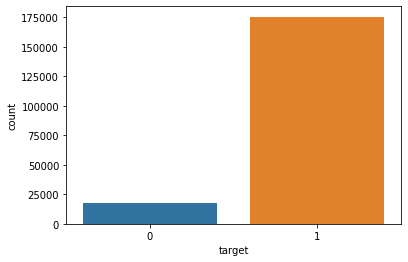

In [25]:
sns.countplot(tn['target'])
sns.set_style('darkgrid')

In [26]:
tn['target'].value_counts()

1    175464
0     17591
Name: target, dtype: int64

([<matplotlib.patches.Wedge at 0x7f15465ec410>,
 [Text(-0.4891234581792461, -0.9852706443707615, 'target_0'),
  Text(0.4891234581792459, 0.9852706443707615, 'target_1')],
 [Text(-0.266794613552316, -0.5374203514749607, '9.1%'),
  Text(0.26679461355231593, 0.5374203514749607, '90.9%')])

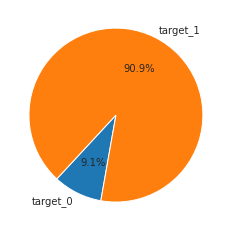

In [27]:
zero=len(tn.loc[tn['target']==0].index)
one=len(tn.loc[tn['target']==1].index)
ratio=[zero, one]
labels=['target_0', 'target_1']
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False)

**최종 검증에 사용할 Test 데이터**

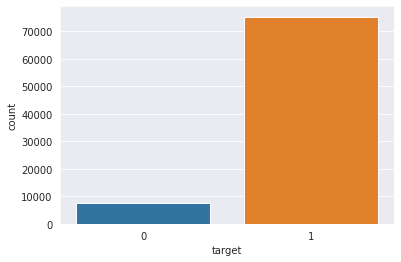

In [28]:
sns.countplot(val['target'])
sns.set_style('darkgrid')

In [29]:
val['target'].value_counts()

1    75381
0     7521
Name: target, dtype: int64

([<matplotlib.patches.Wedge at 0x7f154652e290>,
 [Text(-0.4878925850442335, -0.9858807359203524, 'target_0'),
  Text(0.4878926773490474, 0.9858806902405476, 'target_1')],
 [Text(-0.26612322820594553, -0.5377531286838285, '9.1%'),
  Text(0.26612327855402584, 0.5377531037675713, '90.9%')])

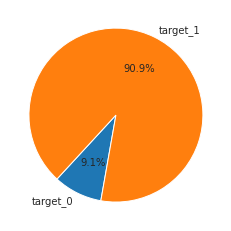

In [30]:
zero=len(val.loc[val['target']==0].index)
one=len(val.loc[val['target']==1].index)
ratio=[zero, one]
labels=['target_0', 'target_1']
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False)

- val 데이터를 의도적으로 불균형하게 만들어 주었습니다.

**실험에 사용할 Train data**

In [31]:
tn_tn, tn_te=train_test_split(tn, test_size=0.3, random_state=42)
# 대회에서는 67, 33으로 2/3와 1/3으로 나누어져 있음. 실험에서는 70:30으로 비율을 나누어서 진행

([<matplotlib.patches.Wedge at 0x7f15464f6e10>,
 [Text(-0.4920152696774862, -0.9838297486883545, 'target_0'),
  Text(0.4920152005928933, 0.9838297832376977, 'target_1')],
 [Text(-0.26837196527862883, -0.536634408375466, '9.2%'),
  Text(0.26837192759612355, 0.5366344272205623, '90.8%')])

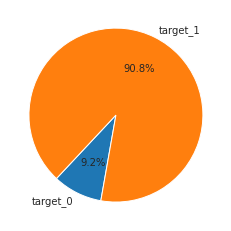

In [32]:
zero=len(tn_tn.loc[tn_tn['target']==0].index)
one=len(tn_tn.loc[tn_tn['target']==1].index)
ratio=[zero, one]
labels=['target_0', 'target_1']
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False)

**실험 검증에 사용할 Train data**

([<matplotlib.patches.Wedge at 0x7f15464c8b10>,
 [Text(-0.48235960838488573, -0.9885996197646345, 'target_0'),
  Text(0.4823595389653519, 0.9885996536359566, 'target_1')],
 [Text(-0.2631052409372104, -0.5392361562352551, '8.9%'),
  Text(0.2631052030720101, 0.5392361747105217, '91.1%')])

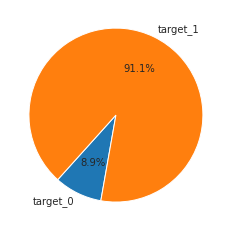

In [33]:
zero=len(tn_te.loc[tn_te['target']==0].index)
one=len(tn_te.loc[tn_te['target']==1].index)
ratio=[zero, one]
labels=['target_0', 'target_1']
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False)

**마지막에 학습시킨Train 원본 데이터 불균형 데이터**

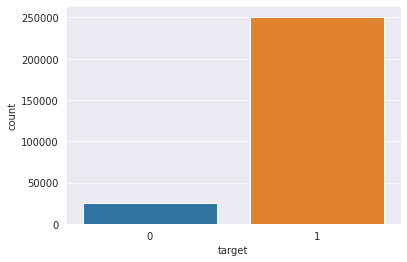

In [34]:
tn_0=train.loc[train['target']==0]
tn_1=train.loc[train['target']==1]
tn_0_tn, tn_00=train_test_split(tn_0, test_size=0.1, random_state=42)
tn_00=tn_00.reset_index()
tn_1=tn_1.reset_index()
tn_A=pd.concat([tn_1, tn_00], axis=0)
tn_A=tn_A.sort_values('index', ascending=True)
tn_A.drop('index', axis=1, inplace=True)
sns.countplot(tn_A['target'])
sns.set_style("darkgrid")

# Imbalance Data Model Selection

In [ ]:
!pip install catboost

In [35]:
from tqdm import tqdm

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import TweedieRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from catboost import CatBoostRegressor

In [37]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [38]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier

In [39]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [40]:
from sklearn.svm import SVC 
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [41]:
from tqdm import tqdm

In [ ]:
x_train=tn.drop('target', axis=1)
y_train=tn['target']
x_test=val.drop('target', axis=1)
y_test=val['target']

In [42]:
lr=LinearRegression()
ridge=Ridge()
lasso=Lasso()
br=BayesianRidge()
tr=TweedieRegressor()
gbR=GradientBoostingRegressor(random_state=42)
rfR=RandomForestRegressor(random_state=42)
xgbR=XGBRegressor(random_state=42)
lgbmR=LGBMRegressor(random_state=42)
#cbR=CatBoostRegressor(random_state=42)

qd=QuadraticDiscriminantAnalysis()
ld=LinearDiscriminantAnalysis()

ridgeCV=RidgeCV()
lassoCV=LassoCV()
bagging=BaggingClassifier(random_state=42)
kneigbors=KNeighborsClassifier()
rfC=RandomForestClassifier(random_state=42)
extra=ExtraTreesClassifier(random_state=42)
ada=AdaBoostClassifier(random_state=42)
gbC=GradientBoostingClassifier(random_state=42)
xgbC=XGBClassifier(random_state=42)
lgbmC=LGBMClassifier(random_state=42)
#cbC=CatBoostClassifier(random_state=42)


gnb=GaussianNB()

svm_clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('liear_svc', LinearSVC(random_state=42))
])

In [ ]:
def model_result(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    pred=model.predict(x_train)
    df_pred=pd.DataFrame(pred, columns=['target'])
    df_pred['target']=df_pred['target'].apply(lambda x:1 if x>=0.5 else 0)
    f_1_tn=f1_score(y_train, df_pred)
    y_pred=model.predict(x_test)
    df_y_pred=pd.DataFrame(y_pred, columns=['target'])
    df_y_pred['target']=df_y_pred['target'].apply(lambda x:1 if x>=0.5 else 0)
    f_1_te=f1_score(y_test, df_y_pred)
    return f_1_tn, f_1_te  

In [ ]:
model_list=[lr, ridge, lasso, br, tr, gbR, rfR, xgbR, lgbmR, cbR,
            ridgeCV,lassoCV,bagging,kneigbors,rfC,extra,ada,gbC,xgbC,lgbmC,cbC,
            qd, ld,gnb,svm_clf]
model_name=['lr', 'ridgeR', 'lassoR', 'brR', 'trR', 'gbR', 'rfR', 'xgbR', 'lgbmR', 'cbR',
               'ridgeCV','lassoCV','baggingC','kneigborsC','rfC','extraC','adaC','gbC','xgbC',
                      'lgbmC','cbC','qd', 'ld','gnb','svm_clf']

df_model=pd.DataFrame(columns=['name','f1_tn_score','f1_te_score'])

k=0
for i in tqdm(model_list):
  name=model_name[k]
  result=model_result(i, x_train, x_test, y_train, y_test)
  df_model=df_model.append({'name':name, 'f1_tn_score':result[0],
                         'f1_te_score':result[1]}, ignore_index=True)
  k+=1

df_model=df_model.sort_values('f1_te_score', ascending=False)
df_model=df_model.reset_index()
df_model.drop('index', axis=1, inplace=True)

In [ ]:
df_model 

,name,f1_tn_score,f1_te_score
0,qd,0.664323,0.794084
1,extraC,1.000000,0.779089
2,svm_clf,0.657619,0.775704
3,brR,0.657669,0.775672
4,ridgeR,0.657638,0.775640
5,ld,0.657647,0.775640
6,lr,0.657647,0.775640
7,ridgeCV,0.647347,0.771507
8,trR,0.638393,0.761067
9,lassoR,0.634975,0.757276


In [ ]:
#x_train=tn.drop('target', axis=1)
#y_train=tn['target']
#x_test=test.copy()

In [ ]:
#model_list=[lr, ridge, lasso, br, tr, gbR, rfR, xgbR, lgbmR, cbR,
#            ridgeCV,lassoCV,bagging,kneigbors,rfC,extra,ada,gbC,xgbC,lgbmC,cbC,
#            qd, ld,gnb,svm_clf]
#model_name=['lr', 'ridgeR', 'lassoR', 'brR', 'trR', 'gbR', 'rfR', 'xgbR', 'lgbmR', 'cbR',
#               'ridgeCV','lassoCV','baggingC','kneigborsC','rfC','extraC','adaC','gbC','xgbC',
#                      'lgbmC','cbC','qd', 'ld','gnb','svm_clf']
#k=0
#
#for md in model_list:
#  name=model_name[k]
#  result=md.fit(x_train, y_train)
#  print(name)
#  y_pred=md.predict(x_test)
#  df_pred=pd.DataFrame(y_pred, columns=['target'])
#  df_pred['target']=df_pred['target'].apply(lambda x:1 if x>=0.5 else 0)
#  sns.countplot(df_pred['target'])
#  plt.show()
#  k+=1

실제 제출 try
--

extra tree classifier

In [ ]:
extra.fit(x_train, y_train)
y_pred=extra.predict(x_test)
df_pred=pd.DataFrame(y_pred, columns=['target'])
df_pred['target']=df_pred['target'].apply(lambda x:1 if x>=0.5 else 0)

([<matplotlib.patches.Wedge at 0x7f2881522a90>,
 [Text(-0.3947747869868006, -1.0267194687739813, 'target_0'),
  Text(0.39477478698680046, 1.0267194687739813, 'target_1')],
 [Text(-0.2153317019928003, -0.5600288011494443, '6.1%'),
  Text(0.21533170199280022, 0.5600288011494443, '93.9%')])

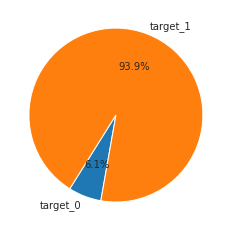

In [ ]:
zero=len(df_pred.loc[df_pred['target']==0].index)
one=len(df_pred.loc[df_pred['target']==1].index)
ratio=[zero, one]
labels=['target_0', 'target_1']
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False)

In [ ]:
df_pred['target'].value_counts()

1    43560
0     2844
Name: target, dtype: int64

In [ ]:
sub_1.drop('target',axis=1, inplace=True)
sub_extra=pd.concat([sub_1, df_pred], axis=1)

In [ ]:
sub_extra.to_csv("sub_extra.csv", index=False)

- 0.6784로 점수가 더 높아짐

- 그 전 최고 기록이 target_1이 89.1%, target_0이 10.9% 였음.

- 어쩌면 test target_1이 99%, test target_0이 1% 아닐까 싶기도...

RidgeCV로 다시 시도

In [ ]:
ridgeCV.fit(x_train, y_train)
y_pred=ridgeCV.predict(x_test)
df_pred=pd.DataFrame(y_pred, columns=['target'])
df_pred['target']=df_pred['target'].apply(lambda x:1 if x>=0.5 else 0)

([<matplotlib.patches.Wedge at 0x7f287c4328d0>,
 [Text(-0.2551747913679548, -1.0699933765450704, 'target_0'),
  Text(0.2551748226742078, 1.0699933690790737, 'target_1')],
 [Text(-0.13918624983706623, -0.5836327508427657, '1.9%'),
  Text(0.13918626691320424, 0.5836327467704038, '98.1%')])

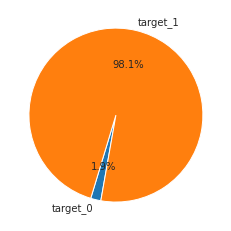

In [ ]:
zero=len(df_pred.loc[df_pred['target']==0].index)
one=len(df_pred.loc[df_pred['target']==1].index)
ratio=[zero, one]
labels=['target_0', 'target_1']
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False)

In [ ]:
df_pred['target'].value_counts()

1    45524
0      880
Name: target, dtype: int64

In [ ]:
sub_ridgeCV=pd.concat([sub_1, df_pred], axis=1)

In [ ]:
sub_ridgeCV.to_csv("sub_ridgeCV.csv", index=False)

- target이 1이 더 많아졌는데도, 점수가 떨어진 거는 이번이 처음 이었다. 따라서 test 데이터의 target_1이 94% 전후로 구성 되어 있다는 판단이 된다. 

|target_1(%)|target_0(%)|score|
|---|---|---|
|89.1%|10.9%|0.6145|
|93.9%|6.1%|0.6784|
|98.1%|1.9%|0.6712|


In [ ]:
def pie_show(df):
  zero=len(df.loc[df['target']==0].index)
  one=len(df.loc[df['target']==1].index)
  ratio=[zero, one]
  labels=['target_0', 'target_1']
  plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False)
  plt.show()

qd


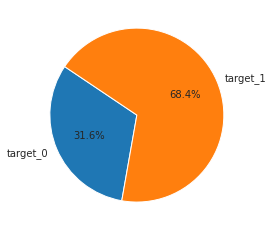

extra


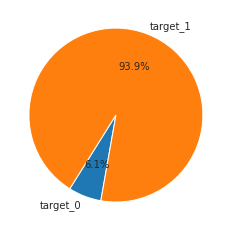

br


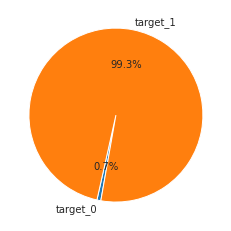

svm_clf


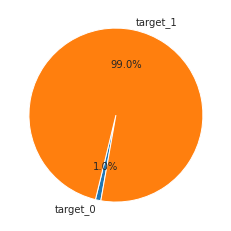

ld


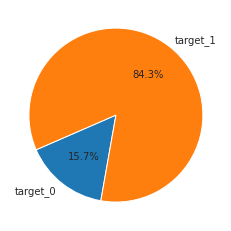

lr


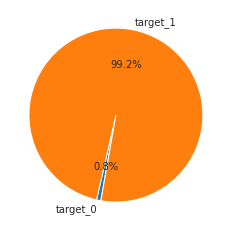

ridge


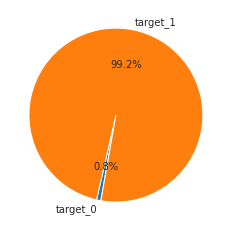

ridgeCV


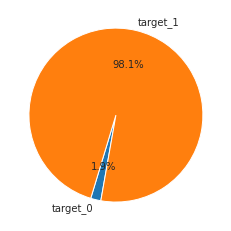

In [ ]:
model_list=[qd,extra,br,svm_clf,ld,lr,ridge,ridgeCV]
model_name=['qd','extra','br','svm_clf','ld','lr','ridge','ridgeCV']
k=0

for md in model_list:
  name=model_name[k]
  result=md.fit(x_train, y_train)
  print(name)
  y_pred=md.predict(x_test)
  df_pred=pd.DataFrame(y_pred, columns=['target'])
  df_pred['target']=df_pred['target'].apply(lambda x:1 if x>=0.5 else 0)
  pie_show(df_pred)
  k+=1

# Feature Selection

**RFE**

- https://hongl.tistory.com/116

Feature Selection의 경우 실험용 학습 데이터인 tn_tn을 학습하여, 실험용 실습 데이터인 tn_te으로 1차 검증하고, 최종 검증 데이터인 val 데이터로 2차 검증하여 이들의 f1_score를 산술 평균으로 구하여, 그에 합당한 feature를 선택한다.

최종 학습데이터로 먼저 feature 순위 정하기
--

In [ ]:
x=tn.drop('target', axis=1)
y=tn['target']

In [ ]:
qd=QuadraticDiscriminantAnalysis()
extra=ExtraTreesClassifier(random_state=42)
svm_clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('liear_svc', LinearSVC(random_state=42))
])

In [ ]:
from sklearn.feature_selection import RFE

rfe=RFE(estimator=extra, n_features_to_select=5)
rfe.fit(x,y)

RFE(estimator=ExtraTreesClassifier(random_state=42), n_features_to_select=5)

In [ ]:
for i in range(x.shape[1]):
  print(f"column {i}, selected : {rfe.support_[i]}, rank: {rfe.ranking_[i]}")

column 0, selected : True, rank: 1
column 1, selected : False, rank: 50
column 2, selected : False, rank: 53
column 3, selected : False, rank: 54
column 4, selected : False, rank: 49
column 5, selected : False, rank: 43
column 6, selected : False, rank: 47
column 7, selected : False, rank: 41
column 8, selected : False, rank: 13
column 9, selected : False, rank: 22
column 10, selected : False, rank: 31
column 11, selected : True, rank: 1
column 12, selected : False, rank: 4
column 13, selected : False, rank: 7
column 14, selected : False, rank: 17
column 15, selected : False, rank: 18
column 16, selected : False, rank: 8
column 17, selected : False, rank: 9
column 18, selected : False, rank: 32
column 19, selected : False, rank: 30
column 20, selected : False, rank: 28
column 21, selected : False, rank: 48
column 22, selected : False, rank: 42
column 23, selected : False, rank: 52
column 24, selected : True, rank: 1
column 25, selected : False, rank: 2
column 26, selected : False, rank

In [ ]:
#from sklearn.model_selection import RepeatedStratifiedKFold
#from sklearn.feature_selection import RFECV
#
#cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
#rfe=RFECV(estimator=extra, cv=cv)
#rfe.fit(x,y)
#
#for i in range(x.shape[1]):
#  print(f"column {i}, selected : {rfe.support_[i]}, rank: {rfe.ranking_[i]}")

**실험용 학습데이터로 학습 후, 1,2차 검증 하기**

RFE 결과 순위

```
rank 1

'id'
'person_prefer_d_1'
'contents_attribute_l'
'person_rn'
'contents_rn'

rank 2 - rank 12

'contents_attribute_d'
'date'
'person_prefer_d_2'
'hour'
'contents_attribute_h'
'person_prefer_d_3'
'person_prefer_h_2'
'person_prefer_h_3'
'contents_attribute_d_n'
'day'
'person_prefer_d_1_n'

rank 13 - 25

'person_attribute_a_1'
'contents_attribute_h_m'
'contents_attribute_e'
'person_prefer_d_2_n'
'person_prefer_e'
'person_prefer_h_1'
'person_prefer_d_3_n'
'person_prefer_h_2_m'
'contents_attribute_d_s'
'person_attribute_b'
'person_prefer_h_3_m'
'person_prefer_d_2_s'
'person_prefer_h_1_m'

rank 26-40

'person_prefer_d_1_s'
'contents_attribute_m'
'contents_attribute_j_1'
'person_prefer_d_3_s'
'contents_attribute_a'
'person_prefer_c'
'contents_attribute_i'
'person_prefer_h_3_l'
'contents_attribute_d_m'
'person_prefer_h_2_l'
'person_prefer_d_2_m'
'contents_attribute_h_l'
'person_prefer_d_1_m'
'person_prefer_d_3_m'
'person_prefer_h_1_l'

rank41-rank 54

person_attribute_a
contents_attribute_c
h_m_match_yn
person_prefer_d_2_l
contents_attribute_d_l
person_prefer_d_3_l
h_s_match_yn
contents_attribute_j
h_l_match_yn
d_l_match_yn
person_prefer_d_1_l
contents_attribute_k
d_m_match_yn
d_s_match_yn
```



In [85]:
col_list=['id',
'person_prefer_d_1',
'contents_attribute_l',
'person_rn',
'contents_rn',
'contents_attribute_d',
'date',
'person_prefer_d_2',
'hour',
'contents_attribute_h',
'person_prefer_d_3',
'person_prefer_h_2',
'person_prefer_h_3',
'contents_attribute_d_n',
'day',
'person_prefer_d_1_n',
  'person_attribute_a_1',
'contents_attribute_h_m',
'contents_attribute_e',
'person_prefer_d_2_n',
'person_prefer_e',
'person_prefer_h_1',
'person_prefer_d_3_n',
'person_prefer_h_2_m',
'contents_attribute_d_s',
'person_attribute_b',
'person_prefer_h_3_m',
'person_prefer_d_2_s',
'person_prefer_h_1_m',
          'person_prefer_d_1_s',
'contents_attribute_m',
'contents_attribute_j_1',
'person_prefer_d_3_s',
'contents_attribute_a',
'person_prefer_c',
'contents_attribute_i',
'person_prefer_h_3_l',
'contents_attribute_d_m',
'person_prefer_h_2_l',
'person_prefer_d_2_m',
'contents_attribute_h_l',
'person_prefer_d_1_m',
'person_prefer_d_3_m',
'person_prefer_h_1_l',
'person_attribute_a',
'contents_attribute_c',
'h_m_match_yn',
'person_prefer_d_2_l',
'contents_attribute_d_l',
'person_prefer_d_3_l',
'h_s_match_yn',
'contents_attribute_j',
'h_l_match_yn',
'd_l_match_yn',
'person_prefer_d_1_l',
'contents_attribute_k',
'd_m_match_yn',
'd_s_match_yn']  

In [86]:
col_list.reverse() # 이 순위를 역순으로 바꾸어서 drop할 feature 선정

In [ ]:
# 1차 검증
x_train=tn_tn.drop('target', axis=1)
y_train=tn_tn['target']
x_test=tn_te.drop('target', axis=1)
y_test=tn_te['target']

# 2차 검증
x=tn.drop('target', axis=1)
y=tn['target']
x_val=val.drop('target', axis=1)
y_val=val['target']

In [ ]:
df_score=pd.DataFrame(columns=['col_values','f1_1_score','f1_2_score','f1_avg_score'])

for i in tqdm(range(len(col_list)-1)):
  extra=ExtraTreesClassifier(random_state=42)
  s=col_list[:i]
  x_tn=x_train.drop(s, axis=1)
  x_te=x_test.drop(s, axis=1)
  extra.fit(x_tn, y_train)
  y_pred_1=extra.predict(x_te)
  f_1_1=f1_score(y_test,y_pred_1)

  x_vn=x.drop(s, axis=1)
  x_ve=x_val.drop(s, axis=1)
  extra.fit(x_vn, y)
  y_pred_2=extra.predict(x_ve)
  f_1_2=f1_score(y_val, y_pred_2)
  f_1_a=(f_1_1+f_1_2)/2
  df_score=df_score.append({'col_values':i, 'f1_1_score':f_1_1, 'f1_2_score':f_1_2
                              ,'f1_avg_score':f_1_a}, ignore_index=True)

df_score=df_score.sort_values('f1_avg_score', ascending=False)

100%|██████████| 57/57 [44:09<00:00, 46.48s/it]


**첫 번째 검증 데이터에서 가장 성적이 좋았던 결과**

In [ ]:
df_score.sort_values('f1_1_score', ascending=False).head(5)

,col_values,f1_1_score,f1_2_score,f1_avg_score
2,2.0,0.953482,0.952522,0.953002
22,22.0,0.953478,0.952481,0.952980
20,20.0,0.953475,0.952499,0.952987
9,9.0,0.953473,0.952416,0.952944
21,21.0,0.953469,0.952504,0.952987


**두 번째 검증 데이터에서 가장 성적이 좋았던 결과**

In [ ]:
df_score.sort_values('f1_2_score', ascending=False).head(5)

,col_values,f1_1_score,f1_2_score,f1_avg_score
25,25.0,0.953336,0.952556,0.952946
26,26.0,0.953409,0.952536,0.952973
2,2.0,0.953482,0.952522,0.953002
21,21.0,0.953469,0.952504,0.952987
11,11.0,0.953420,0.952504,0.952962


**평균적으로 가장 성적이 좋았던 결과**

In [ ]:
df_score.sort_values('f1_avg_score', ascending=False).head(5)

,col_values,f1_1_score,f1_2_score,f1_avg_score
2,2.0,0.953482,0.952522,0.953002
20,20.0,0.953475,0.952499,0.952987
21,21.0,0.953469,0.952504,0.952987
22,22.0,0.953478,0.952481,0.952980
26,26.0,0.953409,0.952536,0.952973


In [ ]:
col_list[:2]

['d_s_match_yn', 'd_m_match_yn']

In [ ]:
col_list[:20]

['d_s_match_yn',
 'd_m_match_yn',
 'contents_attribute_k',
 'person_prefer_d_1_l',
 'd_l_match_yn',
 'h_l_match_yn',
 'contents_attribute_j',
 'h_s_match_yn',
 'person_prefer_d_3_l',
 'contents_attribute_d_l',
 'person_prefer_d_2_l',
 'h_m_match_yn',
 'contents_attribute_c',
 'person_attribute_a',
 'person_prefer_h_1_l',
 'person_prefer_d_3_m',
 'person_prefer_d_1_m',
 'contents_attribute_h_l',
 'person_prefer_d_2_m',
 'person_prefer_h_2_l']

Feature Test(2개 칼럼 제외)
--

In [ ]:
# 1차 검증
x_train=tn_tn.drop(['target','d_s_match_yn', 'd_m_match_yn'], axis=1)
y_train=tn_tn['target']
x_test=tn_te.drop(['target','d_s_match_yn', 'd_m_match_yn'], axis=1)
y_test=tn_te['target']

# 2차 검증
x=tn.drop(['target','d_s_match_yn', 'd_m_match_yn'], axis=1)
y=tn['target']
x_val=val.drop(['target','d_s_match_yn', 'd_m_match_yn'], axis=1)
y_val=val['target']

In [ ]:
extra=ExtraTreesClassifier(random_state=42)
extra.fit(x_train, y_train)
y_pred_1=extra.predict(x_test)
f_1_1=f1_score(y_test,y_pred_1)

extra.fit(x, y)
y_pred_2=extra.predict(x_val)
f_1_2=f1_score(y_val, y_pred_2)
f_1_a=(f_1_1+f_1_2)/2

In [ ]:
print("1차", f_1_1)
print("2차", f_1_2)
print("평균", f_1_a)

1차 0.9534822744410187
2차 0.9525218799008449
평균 0.9530020771709318


In [ ]:
import numpy as np

In [ ]:
def result_show(y_test, y_pred):
  recall=recall_score(y_test, y_pred)
  precision=precision_score(y_test, y_pred)
  f1=2*((precision*recall)/(precision+recall))
  print("recall :", recall)
  print("precision: ", precision)
  print("f1: ", f1)
  auc_roc=classification_report(y_test, y_pred)
  print(auc_roc)
  conf=confusion_matrix(y_test, y_pred)
  sns.heatmap(conf/np.sum(conf), annot=True, cmap='Pastel1', fmt='.2%')
  plt.show()

In [ ]:
def feature_importance_graph(x):
  plt.figure(figsize=(10,30))
  n_feature=x.shape[1]
  index=np.arange(n_feature)
  plt.barh(index, extra.feature_importances_, align='center')
  plt.ylim(-1, n_feature)
  plt.yticks(index, x)
  plt.xlabel('feature importance', size=15)
  plt.ylabel('feature', size=15)
  plt.show()

**1차 검증 결과**

recall : 0.9992987908880718
precision:  0.9116828327886993
f1:  0.9534822744410187
              precision    recall  f1-score   support

           0       0.54      0.01      0.02      5151
           1       0.91      1.00      0.95     52766

    accuracy                           0.91     57917
   macro avg       0.72      0.50      0.48     57917
weighted avg       0.88      0.91      0.87     57917



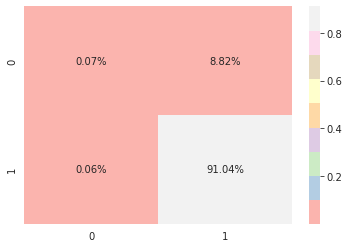

In [ ]:
result_show(y_test, y_pred_1)

**1차 검증 결과 feature importance**

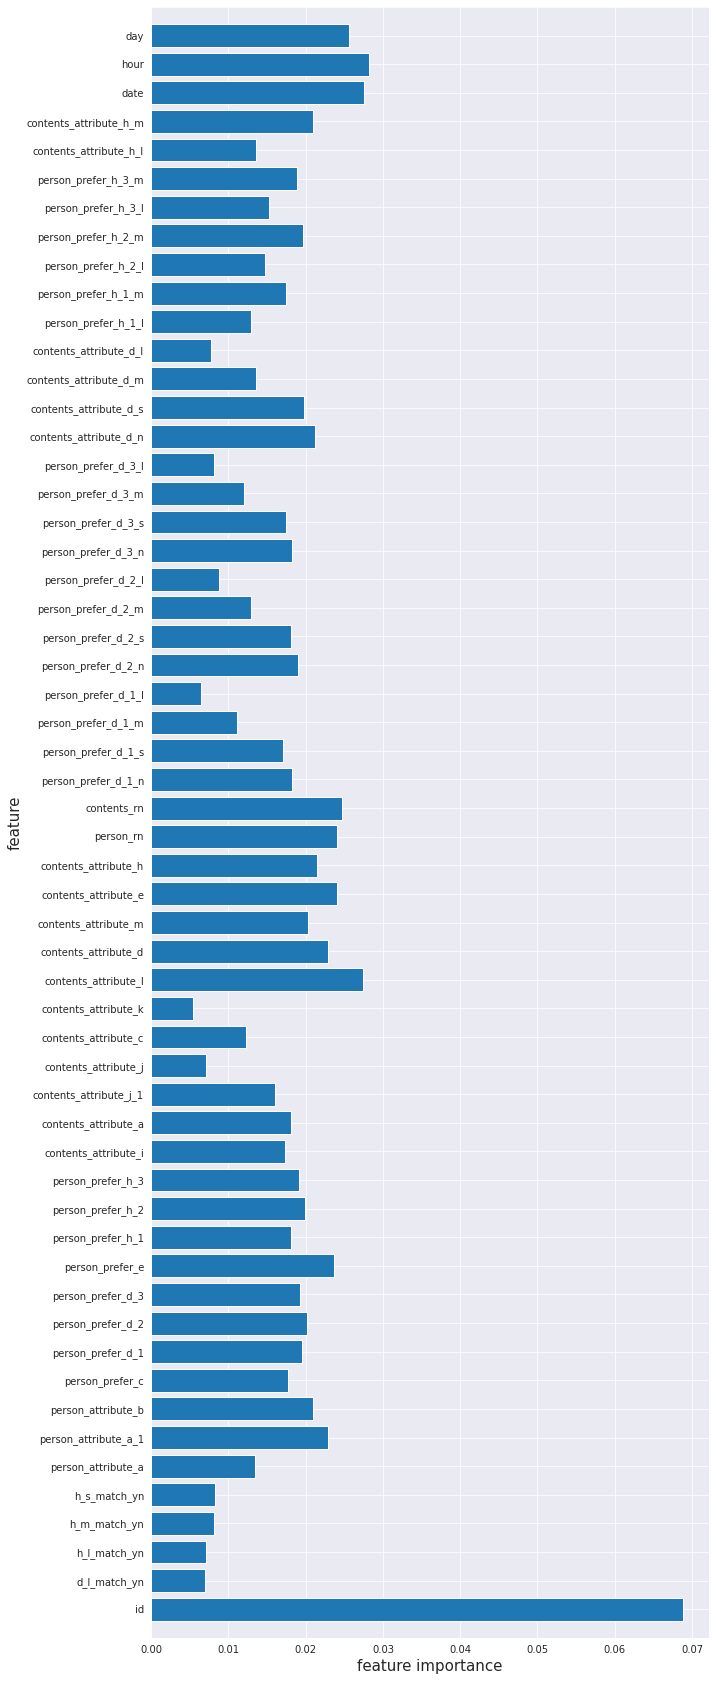

In [ ]:
feature_importance_graph(x_train)

- 1차 검증에서는 h_s_match_yn, h_m_match_yn, h_l_match_yn, d_l_match_yn, contents_attribute_k, contents_attribute_j, person_prefer_d_1_l, person_prefer_d_2_l, person_prefer_d_3_l,contents_attribute_d_l 정도가 낮게 나타난다. 

**2차 검증 결과**

recall : 0.9991111818628037
precision:  0.910083982840916
f1:  0.9525218799008449
              precision    recall  f1-score   support

           0       0.54      0.01      0.02      7521
           1       0.91      1.00      0.95     75381

    accuracy                           0.91     82902
   macro avg       0.73      0.50      0.49     82902
weighted avg       0.88      0.91      0.87     82902



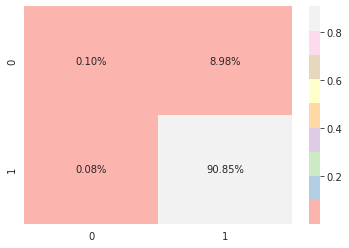

In [ ]:
result_show(y_val, y_pred_2)

**2차 검증 결과 feature importance**

In [ ]:
feature_importance_graph(x_val)

- 2차 검증에서도 큰 차이 없음.

칼럼 20개 제외하고 결과 보기
--

extra: 별 차이 없음

qd: 오히려 떨어짐

In [106]:
# 1차 검증
x_train=tn_tn.drop(['target','d_s_match_yn',
 'd_m_match_yn',
 'contents_attribute_k',
 'person_prefer_d_1_l',
 'd_l_match_yn',
 'h_l_match_yn',
 'contents_attribute_j',
 'h_s_match_yn',
 'person_prefer_d_3_l',
 'contents_attribute_d_l',
 'person_prefer_d_2_l',
 'h_m_match_yn',
 'contents_attribute_c',
 'person_attribute_a',
 'person_prefer_h_1_l',
 'person_prefer_d_3_m',
 'person_prefer_d_1_m',
 'contents_attribute_h_l',
 'person_prefer_d_2_m',
 'person_prefer_h_2_l'], axis=1)
y_train=tn_tn['target']
x_test=tn_te.drop(['target','d_s_match_yn',
 'd_m_match_yn',
 'contents_attribute_k',
 'person_prefer_d_1_l',
 'd_l_match_yn',
 'h_l_match_yn',
 'contents_attribute_j',
 'h_s_match_yn',
 'person_prefer_d_3_l',
 'contents_attribute_d_l',
 'person_prefer_d_2_l',
 'h_m_match_yn',
 'contents_attribute_c',
 'person_attribute_a',
 'person_prefer_h_1_l',
 'person_prefer_d_3_m',
 'person_prefer_d_1_m',
 'contents_attribute_h_l',
 'person_prefer_d_2_m',
 'person_prefer_h_2_l'], axis=1)
y_test=tn_te['target']

# 2차 검증
x=tn.drop(['target','d_s_match_yn',
 'd_m_match_yn',
 'contents_attribute_k',
 'person_prefer_d_1_l',
 'd_l_match_yn',
 'h_l_match_yn',
 'contents_attribute_j',
 'h_s_match_yn',
 'person_prefer_d_3_l',
 'contents_attribute_d_l',
 'person_prefer_d_2_l',
 'h_m_match_yn',
 'contents_attribute_c',
 'person_attribute_a',
 'person_prefer_h_1_l',
 'person_prefer_d_3_m',
 'person_prefer_d_1_m',
 'contents_attribute_h_l',
 'person_prefer_d_2_m',
 'person_prefer_h_2_l'], axis=1)
y=tn['target']
x_val=val.drop(['target','d_s_match_yn',
 'd_m_match_yn',
 'contents_attribute_k',
 'person_prefer_d_1_l',
 'd_l_match_yn',
 'h_l_match_yn',
 'contents_attribute_j',
 'h_s_match_yn',
 'person_prefer_d_3_l',
 'contents_attribute_d_l',
 'person_prefer_d_2_l',
 'h_m_match_yn',
 'contents_attribute_c',
 'person_attribute_a',
 'person_prefer_h_1_l',
 'person_prefer_d_3_m',
 'person_prefer_d_1_m',
 'contents_attribute_h_l',
 'person_prefer_d_2_m',
 'person_prefer_h_2_l'], axis=1)
y_val=val['target']

In [109]:
extra=ExtraTreesClassifier(random_state=42)
extra.fit(x_train, y_train)
y_pred_1=extra.predict(x_test)
f_1_1=f1_score(y_test,y_pred_1)

extra.fit(x, y)
y_pred_2=extra.predict(x_val)
f_1_2=f1_score(y_val, y_pred_2)
f_1_a=(f_1_1+f_1_2)/2

In [110]:
print("1차", f_1_1)
print("2차", f_1_2)
print("평균", f_1_a)

1차 0.9534751285829213
2차 0.9524989569241273
평균 0.9529870427535243


**1차 검증 결과**

recall : 0.999526210059508
precision:  0.9114805661649068
f1:  0.9534751285829213
              precision    recall  f1-score   support

           0       0.54      0.01      0.01      5151
           1       0.91      1.00      0.95     52766

    accuracy                           0.91     57917
   macro avg       0.72      0.50      0.48     57917
weighted avg       0.88      0.91      0.87     57917



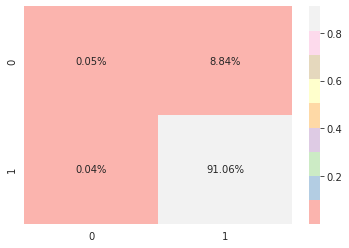

In [ ]:
result_show(y_test, y_pred_1)

**1차 검증 결과 feature importance**

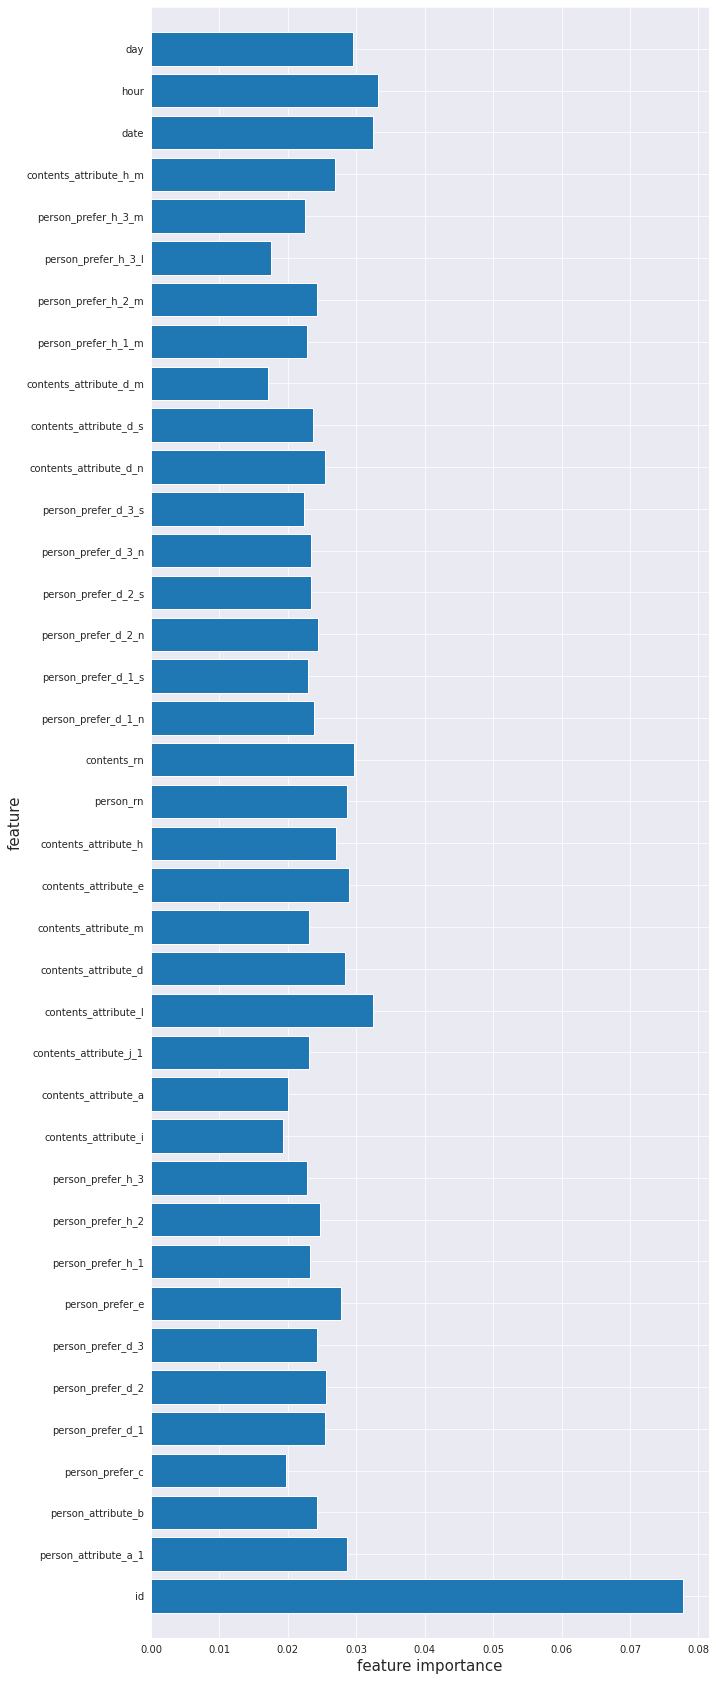

In [ ]:
feature_importance_graph(x_train)

- person_prefer_h_3_l, contentes_attribute_d_m, person_prfer_3 제외하고는 대부분 잘 나오는 편

- contents_attribute_l, data, hour이 높은 편이다.

**2차 검증 결과**

recall : 0.9994030325944203
precision:  0.9098001328422197
f1:  0.9524989569241273
              precision    recall  f1-score   support

           0       0.54      0.01      0.01      7521
           1       0.91      1.00      0.95     75381

    accuracy                           0.91     82902
   macro avg       0.72      0.50      0.48     82902
weighted avg       0.88      0.91      0.87     82902



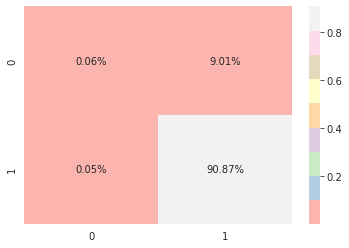

In [ ]:
result_show(y_val, y_pred_2)

**2차 검증 결과 feature importance**

In [ ]:
feature_importance_graph(x_val)

- 2차도 1차와 큰 차이 없음

# Feature Engineering

선택된 Feature 기반으로 Scaling 및 더미변수 부여 등 변수들을 Enginering 하여, 최종 학습 데이터와 최종 검증 데이터를 tuning 한다.


In [130]:
# 1차 검증
x_train=tn_tn.drop(['target','d_s_match_yn', 'd_m_match_yn'], axis=1)
y_train=tn_tn['target']
x_test=tn_te.drop(['target','d_s_match_yn', 'd_m_match_yn'], axis=1)
y_test=tn_te['target']

# 2차 검증
x=tn.drop(['target','d_s_match_yn', 'd_m_match_yn'], axis=1)
y=tn['target']
x_val=val.drop(['target','d_s_match_yn', 'd_m_match_yn'], axis=1)
y_val=val['target']

# Extra Classifier Engineering

**Scaling**

In [114]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [115]:
mm=MinMaxScaler()
ss=StandardScaler()
rr=RobustScaler()

In [116]:
def scaling_result(s, x_train,y_train, x_test, y_test, x,y,x_val,y_val):
  x_train=s.fit_transform(x_train)
  x_test=s.fit_transform(x_test)
  x=s.fit_transform(x)
  x_val=s.fit_transform(x_val)

  extra=ExtraTreesClassifier()
  extra.fit(x_train, y_train)
  y_pred_1=extra.predict(x_test)
  f_1_1=f1_score(y_test,y_pred_1)
  extra.fit(x, y)
  y_pred_2=extra.predict(x_val)
  f_1_2=f1_score(y_val, y_pred_2)
  f_1_a=(f_1_1+f_1_2)/2
  print("f1_1차 : ", f_1_1)
  print("f1_2차 : ", f_1_2 )
  print("f1 avg score :", f_1_a)

Scaling
--

이전에 2개 칼럼 제외 했을 때, 성적

```
1차 0.9534822744410187
2차 0.9525218799008449
평균 0.9530020771709318
```

**MinMax Scaler**

In [ ]:
scaling_result(mm, x_train, y_train, x_test, y_test, x,y,x_val, y_val)

**Standard Scaler**

In [ ]:
scaling_result(ss, x_train, y_train, x_test, y_test, x,y,x_val, y_val)

**Robust Scaler**

In [122]:
scaling_result(rr, x_train, y_train, x_test, y_test, x,y,x_val, y_val)

더미화 진행
--

In [87]:
col_list.reverse() #다시 중요한 순서대로 바꾸어줍니다.

**중요도 낮은 변수 20개 제거시**

In [88]:
new_col=col_list[:-20]

In [89]:
col_1=[]

for col in new_col:
  len_value=len(x[col].unique())
  if len_value<50:
    col_1.append(col)
    print(col,":", len_value)

date : 31
hour : 24
day : 7
person_attribute_a_1 : 8
contents_attribute_e : 12
person_prefer_e : 12
person_attribute_b : 6
contents_attribute_m : 5
contents_attribute_j_1 : 9
contents_attribute_a : 3
person_prefer_c : 5
contents_attribute_i : 3
person_prefer_h_3_l : 19
contents_attribute_d_m : 33


In [90]:
len(col_1)

14

In [91]:
df_unique=pd.DataFrame(columns=['col_name','len_unique','mix','max','mean','std'])

for i in range(len(tn.columns)):
    col=tn.columns[i]
    
    if col in col_1:
        len_unique=len(tn[col].unique())
        min_col=tn[col].min()
        max_col=tn[col].max()
        mean_col=tn[col].mean()
        std_col=tn[col].std()
        df_unique=df_unique.append({'col_name':col,'len_unique':len_unique,'mix':min_col,'max':max_col,'mean':mean_col,'std':std_col}, ignore_index=True)

df_unique=df_unique.sort_values("len_unique", ascending=True)
df_unique=df_unique.loc[df_unique['col_name']!='id']
df_unique=df_unique.reset_index()
df_unique.drop("index", axis=1, inplace=True)

In [92]:
df_unique

,col_name,len_unique,mix,max,mean,std
0,contents_attribute_i,3,1,3,2.456730,0.838708
1,contents_attribute_a,3,1,3,2.326368,0.889975
2,person_prefer_c,5,1,5,2.403564,1.834012
3,contents_attribute_m,5,1,5,2.219399,1.556634
4,person_attribute_b,6,0,5,2.779239,0.889558
5,day,7,0,6,3.197664,2.150933
6,person_attribute_a_1,8,0,7,2.623097,2.418438
7,contents_attribute_j_1,9,1,10,5.877087,2.068064
8,person_prefer_e,12,0,11,3.679744,1.875217
9,contents_attribute_e,12,0,11,3.946575,1.149511


In [93]:
col_1

['date',
 'hour',
 'day',
 'person_attribute_a_1',
 'contents_attribute_e',
 'person_prefer_e',
 'person_attribute_b',
 'contents_attribute_m',
 'contents_attribute_j_1',
 'contents_attribute_a',
 'person_prefer_c',
 'contents_attribute_i',
 'person_prefer_h_3_l',
 'contents_attribute_d_m']

In [94]:
def make_dummy(df, col_1):
  df_1=pd.get_dummies(df[col_1[0]], prefix=col_1[0])
  df_2=pd.get_dummies(df[col_1[1]], prefix=col_1[1])
  df_3=pd.get_dummies(df[col_1[2]], prefix=col_1[2])
  df_4=pd.get_dummies(df[col_1[3]], prefix=col_1[3])
  df_5=pd.get_dummies(df[col_1[4]], prefix=col_1[4])
  df_6=pd.get_dummies(df[col_1[5]], prefix=col_1[5])
  df_7=pd.get_dummies(df[col_1[6]], prefix=col_1[6])
  df_8=pd.get_dummies(df[col_1[7]], prefix=col_1[7])
  df_9=pd.get_dummies(df[col_1[8]], prefix=col_1[8])
  df_10=pd.get_dummies(df[col_1[9]], prefix=col_1[9])
  df_11=pd.get_dummies(df[col_1[10]], prefix=col_1[10])
  df_12=pd.get_dummies(df[col_1[11]], prefix=col_1[11])
  df_13=pd.get_dummies(df[col_1[12]], prefix=col_1[12])
  df_14=pd.get_dummies(df[col_1[13]], prefix=col_1[13])
  return df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12, df_13, df_14

In [95]:
def make_dummy_2(df, col_1):
  A=make_dummy(df, col_1)[0]
  B=make_dummy(df, col_1)[1]
  C=make_dummy(df, col_1)[2]
  D=make_dummy(df, col_1)[3]
  E=make_dummy(df, col_1)[4]
  F=make_dummy(df, col_1)[5]
  G=make_dummy(df, col_1)[6]
  H=make_dummy(df, col_1)[7]
  I=make_dummy(df, col_1)[8]
  J=make_dummy(df, col_1)[9]
  K=make_dummy(df, col_1)[10]
  L=make_dummy(df, col_1)[11]
  M=make_dummy(df, col_1)[12]
  N=make_dummy(df, col_1)[13]
  new_df=pd.concat([df, A,B,C,D,E,F,G,H,I,H,K,L,M,N], axis=1)
  return new_df

In [96]:
x_train_d=make_dummy_2(x_train, col_1)
x_test_d=make_dummy_2(x_test, col_1)
x_d=make_dummy_2(x, col_1)
x_val_d=make_dummy_2(x_val, col_1)

In [97]:
print(len(x_train_d.columns))
print(len(x_test_d.columns))
print(len(x_d.columns))
print(len(x_val_d.columns))

235
235
235
236


In [98]:
set(x_val_d.columns)-set(x_d.columns)

{'contents_attribute_d_m_1258'}

In [99]:
x_val_d.drop("contents_attribute_d_m_1258", axis=1, inplace=True)

In [101]:
def dummy_result(x_train,y_train, x_test, y_test, x,y,x_val,y_val):
  extra=ExtraTreeClassifier(random_state=42)
  extra.fit(x_train, y_train)
  y_pred_1=extra.predict(x_test)
  f_1_1=f1_score(y_test,y_pred_1)
  extra.fit(x, y)
  y_pred_2=extra.predict(x_val)
  f_1_2=f1_score(y_val, y_pred_2)
  f_1_a=(f_1_1+f_1_2)/2
  print("f1_1차 : ", f_1_1)
  print("f1_2차 : ", f_1_2 )
  print("f1 avg score :", f_1_a)

In [ ]:
dummy_result(x_train_d, y_train, x_test_d, y_test, x_d, y, x_val_d, y_val)

**더미화 후, scaling**

In [ ]:
scaling_result(mm, x_train_d, y_train, x_test_d, y_test, x_d, y, x_val_d, y_val)

In [ ]:
scaling_result(rr, x_train_d, y_train, x_test_d, y_test, x_d, y, x_val_d, y_val)

In [ ]:
scaling_result(ss, x_train_d, y_train, x_test_d, y_test, x_d, y, x_val_d, y_val)

- 큰 의미가 없으므로, 처음 변수를 2개 제거 했던 것으로 Hyperparameter Tuning 시작

# QDA Feature Engineering

판별 분석에 대한 데이터 고려 사항

```
예측 변수가 양적 변수여야 함.

예측 변수들이 깊이 상관되지 않아야 함.

반응 변수가 그룹을 나타내야 함.

예측 변수에 대한 데이터가 각 그룹별로 정규 분포를 따라야 함.

가능한 경우 분석을 위한 사전 확률 입력
```

참고링크: https://support.minitab.com/ko-kr/minitab/18/help-and-how-to/modeling-statistics/multivariate/how-to/discriminant-analysis/before-you-start/data-considerations/

판별 분석의 가설

귀무가설: 두 개 또는 그 이상의 집단의 평균이 동일하다.

대립가설: 두 개 또는 그 이상의 집단의 평균이 동일하지 않다.

판별 분석의 가정들

```
독립 변수들의 결합확률 분포는 다변량 정규분포이다.

모집단에서 종속변수의 각 그룹 별로 독립변수들의 공분산 구조가 같다. -> Box-M 검정을 이용

각 그룹에 소속될 사전확률은 같다.
```

판별분석 가정의 점검

```
각 독립 변수들의 분포가 정규분포인가?

그룹 별 독립 변수들은 등분산성을 만족하는 가?
-> Box-M 검정을 이용

각 그룹에 소속될 사전 확률은 같은가?
```
- 참고 링크 : http://contents.kocw.net/KOCW/document/2015/dongguk/shimkyubark1/10-2.pdf

다중공선성 점검
--

In [168]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [154]:
x_A=tn_A.drop(['target'], axis=1)
y_A=tn_A['target']

In [155]:
x_constant=sm.add_constant(x_A)

model=sm.OLS(y_A,x_constant).fit()

In [156]:
p_values_1=pd.DataFrame(model.pvalues, columns=['p-value'])
p_values_1=p_values_1.sort_values(by='p-value', ascending=False)
p_over=p_values_1.loc[p_values_1['p-value']>0.05]
p_over

,p-value
person_prefer_h_3,0.982947
person_prefer_h_3_m,0.878486
person_prefer_h_1,0.858876
person_prefer_d_3_l,0.765408
hour,0.759579
contents_attribute_h_l,0.741355
date,0.738762
day,0.460676
person_prefer_h_2,0.447151
person_prefer_h_2_m,0.403180


p-value 0.05 이상 제거 후 확인해보기

In [158]:
x_A=tn_A.drop(['target','person_prefer_h_3', 'person_prefer_h_3_m', 'person_prefer_h_1',
       'person_prefer_d_3_l', 'hour', 'contents_attribute_h_l', 'date', 'day',
       'person_prefer_h_2', 'person_prefer_h_2_m', 'person_prefer_h_2_l',
       'person_prefer_h_3_l', 'contents_attribute_l', 'h_s_match_yn',
       'contents_attribute_h', 'contents_attribute_h_m'], axis=1)
y_A=tn_A['target']

In [159]:
x_constant=sm.add_constant(x_A)

model=sm.OLS(y_A,x_constant).fit()
p_values_1=pd.DataFrame(model.pvalues, columns=['p-value'])
p_values_1=p_values_1.sort_values(by='p-value', ascending=False)
p_over=p_values_1.loc[p_values_1['p-value']>0.05]
p_over

,p-value


변수 제거 후 확인해보기
--


In [163]:
def result(model, x_train,y_train, x_test, y_test, x,y,x_val,y_val):
  model.fit(x_train, y_train)
  y_pred_1=model.predict(x_test)
  f_1_1=f1_score(y_test,y_pred_1)
  recall_1=recall_score(y_test, y_pred_1)
  precision_1=precision_score(y_test, y_pred_1)
  print("recall 1차 :", recall_1)
  print("precision 1차: ", precision_1)
  print("f1_1차 : ", f_1_1)
  auc_roc=classification_report(y_test, y_pred_1)
  print(auc_roc)
  conf=confusion_matrix(y_test, y_pred_1)
  sns.heatmap(conf/np.sum(conf), annot=True, cmap='Pastel1', fmt='.2%')
  plt.show()

  model.fit(x, y)
  y_pred_2=model.predict(x_val)
  f_1_2=f1_score(y_val, y_pred_2)
  recall_2=recall_score(y_val, y_pred_2)
  precision_2=precision_score(y_val, y_pred_2)
  print("recall 2차 :", recall_2)
  print("precision 2차: ", precision_2)
  print("f1_2차 : ", f_1_2 )
  auc_roc=classification_report(y_val, y_pred_2)
  print(auc_roc)
  conf=confusion_matrix(y_val, y_pred_2)
  sns.heatmap(conf/np.sum(conf), annot=True, cmap='Pastel1', fmt='.2%')
  plt.show()

  f_1_a=(f_1_1+f_1_2)/2
  print("f1 avg score :", f_1_a)

In [164]:
# 1차 검증
x_train=tn_tn.drop(['target','person_prefer_h_3', 'person_prefer_h_3_m', 'person_prefer_h_1',
       'person_prefer_d_3_l', 'hour', 'contents_attribute_h_l', 'date', 'day',
       'person_prefer_h_2', 'person_prefer_h_2_m', 'person_prefer_h_2_l',
       'person_prefer_h_3_l', 'contents_attribute_l', 'h_s_match_yn',
       'contents_attribute_h', 'contents_attribute_h_m'], axis=1)
y_train=tn_tn['target']
x_test=tn_te.drop(['target','person_prefer_h_3', 'person_prefer_h_3_m', 'person_prefer_h_1',
       'person_prefer_d_3_l', 'hour', 'contents_attribute_h_l', 'date', 'day',
       'person_prefer_h_2', 'person_prefer_h_2_m', 'person_prefer_h_2_l',
       'person_prefer_h_3_l', 'contents_attribute_l', 'h_s_match_yn',
       'contents_attribute_h', 'contents_attribute_h_m'], axis=1)
y_test=tn_te['target']

# 2차 검증
x=tn.drop(['target','person_prefer_h_3', 'person_prefer_h_3_m', 'person_prefer_h_1',
       'person_prefer_d_3_l', 'hour', 'contents_attribute_h_l', 'date', 'day',
       'person_prefer_h_2', 'person_prefer_h_2_m', 'person_prefer_h_2_l',
       'person_prefer_h_3_l', 'contents_attribute_l', 'h_s_match_yn',
       'contents_attribute_h', 'contents_attribute_h_m'], axis=1)
y=tn['target']
x_val=val.drop(['target','person_prefer_h_3', 'person_prefer_h_3_m', 'person_prefer_h_1',
       'person_prefer_d_3_l', 'hour', 'contents_attribute_h_l', 'date', 'day',
       'person_prefer_h_2', 'person_prefer_h_2_m', 'person_prefer_h_2_l',
       'person_prefer_h_3_l', 'contents_attribute_l', 'h_s_match_yn',
       'contents_attribute_h', 'contents_attribute_h_m'], axis=1)
y_val=val['target']

In [166]:
ss=StandardScaler()
s_x_train=ss.fit_transform(x_train)
s_x_test=ss.fit_transform(x_test)
s_x=ss.fit_transform(x)
s_x_val=ss.fit_transform(x_val)

df_x_train=pd.DataFrame(s_x_train , index=x_train.index , columns=x_train.columns )
df_x_test=pd.DataFrame(s_x_test , index=x_test.index , columns=x_test.columns )
df_x=pd.DataFrame(s_x , index=x.index , columns=x.columns )
df_x_val=pd.DataFrame(s_x_val , index=x_val.index , columns=x_val.columns )

recall 1차 : 0.9469923814577569
precision 1차:  0.9214102635024248
f1_1차 :  0.934026187650121
              precision    recall  f1-score   support

           0       0.24      0.17      0.20      5151
           1       0.92      0.95      0.93     52766

    accuracy                           0.88     57917
   macro avg       0.58      0.56      0.57     57917
weighted avg       0.86      0.88      0.87     57917



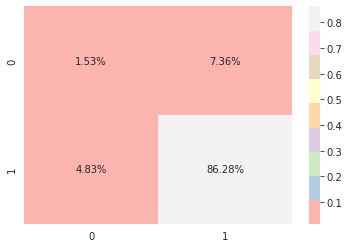

recall 2차 : 0.9476393255594912
precision 2차:  0.9195932028836251
f1_2차 :  0.9334056356615988
              precision    recall  f1-score   support

           0       0.24      0.17      0.20      7521
           1       0.92      0.95      0.93     75381

    accuracy                           0.88     82902
   macro avg       0.58      0.56      0.57     82902
weighted avg       0.86      0.88      0.87     82902



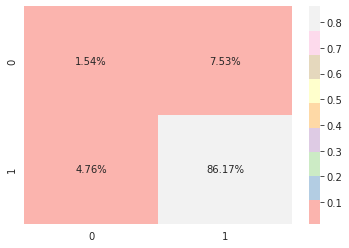

f1 avg score : 0.93371591165586


In [165]:
result(qd, x_train,y_train, x_test, y_test, x,y,x_val,y_val)

recall 1차 : 0.9474661713982488
precision 1차:  0.9213615672398223
f1_1차 :  0.934231549048371
              precision    recall  f1-score   support

           0       0.24      0.17      0.20      5151
           1       0.92      0.95      0.93     52766

    accuracy                           0.88     57917
   macro avg       0.58      0.56      0.57     57917
weighted avg       0.86      0.88      0.87     57917



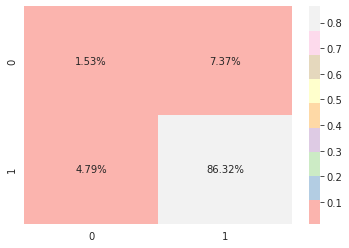

recall 2차 : 0.947692389328876
precision 2차:  0.9195973430822306
f1_2차 :  0.9334335086401202
              precision    recall  f1-score   support

           0       0.24      0.17      0.20      7521
           1       0.92      0.95      0.93     75381

    accuracy                           0.88     82902
   macro avg       0.58      0.56      0.57     82902
weighted avg       0.86      0.88      0.87     82902



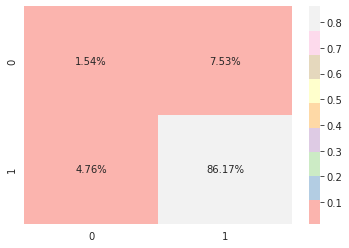

f1 avg score : 0.9338325288442456


In [167]:
result(qd, df_x_train,y_train, df_x_test, y_test, df_x,y,df_x_val,y_val)

VIF로 추가 진단하여 변수 제거하기

In [171]:
s_x_A=ss.fit_transform(x_A)
df_x_A=pd.DataFrame(s_x_A , index=x_A.index , columns=x_A.columns )

In [172]:
vif = pd.DataFrame()
vif['VIF Factor']=[variance_inflation_factor(df_x_A.values, i) for i in range(df_x_A.shape[1])]
vif['features']=df_x_A.columns
vif=vif.sort_values(by='VIF Factor', ascending=False)
vif.loc[vif['VIF Factor']>10].head(10)

,VIF Factor,features
25,44968.588306,person_prefer_d_1_n
29,44930.599478,person_prefer_d_2_n
33,44209.146605,person_prefer_d_3_n
12,43876.254322,person_prefer_d_3
36,41712.476181,contents_attribute_d_n
10,37231.999184,person_prefer_d_1
11,36182.891659,person_prefer_d_2
20,34722.521202,contents_attribute_d
26,7898.124728,person_prefer_d_1_s
30,7446.072837,person_prefer_d_2_s


In [214]:
vif_over=vif.loc[vif['VIF Factor']>10]

In [215]:
vif_over.features.values

array(['person_prefer_d_1_n', 'person_prefer_d_2_n',
       'person_prefer_d_3_n', 'person_prefer_d_3',
       'contents_attribute_d_n', 'person_prefer_d_1', 'person_prefer_d_2',
       'contents_attribute_d', 'person_prefer_d_1_s',
       'person_prefer_d_2_s', 'contents_attribute_d_s',
       'person_prefer_d_3_s', 'person_prefer_d_1_m',
       'person_prefer_d_3_m', 'contents_attribute_d_m',
       'person_prefer_d_2_m', 'person_prefer_h_1_m',
       'person_prefer_h_1_l', 'person_prefer_d_2_l',
       'person_prefer_d_1_l', 'contents_attribute_d_l'], dtype=object)

판별 분석의 가설
--

```
귀무가설: 두 개의 집단의 평균이 동일하다

대립가설: 두 개 또는 그 이상의 집단의 평균이 동일하지 않다.
```

Train_0 vs Train_1

In [173]:
import scipy

In [176]:
tn_0=tn_A.loc[tn_A['target']==0]
tn_1=tn_A.loc[tn_A['target']==1]

In [180]:
tn_11, tn_sam=train_test_split(tn_1, test_size=0.1, random_state=42)

In [183]:
tn_0=tn_0.reset_index()
tn_0=tn_0.iloc[:25085, :]
tn_0.drop('index', axis=1, inplace=True)

In [184]:
tn_sam=tn_sam.reset_index()
tn_sam.drop('index', axis=1, inplace=True)

In [187]:
print(len(tn_0.index))
print(len(tn_0.columns))

25085
59


In [188]:
print(len(tn_sam.index))
print(len(tn_sam.columns))

25085
59


In [189]:
same_tnte=pd.DataFrame(columns=['name','p-value'])
diff_tnte=pd.DataFrame(columns=['name','p-value'])

for i in range(1,len(tn_sam.columns)):
  col=tn_sam.columns[i]
  t_result=scipy.stats.ttest_rel(tn_sam.iloc[:, i], tn_0.iloc[:, i])
  if t_result[1]<0.05:
    diff_tnte=diff_tnte.append({'name':col,'p-value':t_result[1]}, ignore_index=True)
  else:
    same_tnte=same_tnte.append({'name':col,'p-value':t_result[1]}, ignore_index=True)

In [ ]:
diff_tnte.sort_values('p-value', ascending=True)

In [ ]:
diff_tnte.name.values

In [193]:
same_tnte.name.values

array(['h_m_match_yn', 'h_s_match_yn', 'person_attribute_b',
       'contents_attribute_j_1', 'date', 'hour', 'day'], dtype=object)

3대장 끼리 모여서 회의하기
--

In [216]:
diff_set=['d_l_match_yn', 'd_m_match_yn', 'd_s_match_yn', 'h_l_match_yn',
       'person_attribute_a', 'person_attribute_a_1', 'person_prefer_c',
       'person_prefer_d_1', 'person_prefer_d_2', 'person_prefer_d_3',
       'person_prefer_e', 'person_prefer_h_1', 'person_prefer_h_2',
       'person_prefer_h_3', 'contents_attribute_i',
       'contents_attribute_a', 'contents_attribute_j',
       'contents_attribute_c', 'contents_attribute_k',
       'contents_attribute_l', 'contents_attribute_d',
       'contents_attribute_m', 'contents_attribute_e',
       'contents_attribute_h', 'person_rn', 'contents_rn',
       'person_prefer_d_1_n', 'person_prefer_d_1_s',
       'person_prefer_d_1_m', 'person_prefer_d_1_l',
       'person_prefer_d_2_n', 'person_prefer_d_2_s',
       'person_prefer_d_2_m', 'person_prefer_d_2_l',
       'person_prefer_d_3_n', 'person_prefer_d_3_s',
       'person_prefer_d_3_m', 'person_prefer_d_3_l',
       'contents_attribute_d_n', 'contents_attribute_d_s',
       'contents_attribute_d_m', 'contents_attribute_d_l',
       'person_prefer_h_1_l', 'person_prefer_h_1_m',
       'person_prefer_h_2_l', 'person_prefer_h_2_m',
       'person_prefer_h_3_l', 'person_prefer_h_3_m',
       'contents_attribute_h_l', 'contents_attribute_h_m']

vif_set=['person_prefer_d_1_n', 'person_prefer_d_2_n',
       'person_prefer_d_3_n', 'person_prefer_d_3',
       'contents_attribute_d_n', 'person_prefer_d_1', 'person_prefer_d_2',
       'contents_attribute_d', 'person_prefer_d_1_s',
       'person_prefer_d_2_s', 'contents_attribute_d_s',
       'person_prefer_d_3_s', 'person_prefer_d_1_m',
       'person_prefer_d_3_m', 'contents_attribute_d_m',
       'person_prefer_d_2_m', 'person_prefer_h_1_m',
       'person_prefer_h_1_l', 'person_prefer_d_2_l',
       'person_prefer_d_1_l', 'contents_attribute_d_l']

pval_set=['person_prefer_h_3', 'person_prefer_h_3_m', 'person_prefer_h_1',
       'person_prefer_d_3_l', 'hour', 'contents_attribute_h_l', 'date', 'day',
       'person_prefer_h_2', 'person_prefer_h_2_m', 'person_prefer_h_2_l',
       'person_prefer_h_3_l', 'contents_attribute_l', 'h_s_match_yn',
       'contents_attribute_h', 'contents_attribute_h_m']

In [237]:
(set(vif_set))-(set(diff_set))

set()

In [238]:
(set(pval_set))-(set(vif_set))

{'contents_attribute_h',
 'contents_attribute_h_l',
 'contents_attribute_h_m',
 'contents_attribute_l',
 'date',
 'day',
 'h_s_match_yn',
 'hour',
 'person_prefer_d_3_l',
 'person_prefer_h_1',
 'person_prefer_h_2',
 'person_prefer_h_2_l',
 'person_prefer_h_2_m',
 'person_prefer_h_3',
 'person_prefer_h_3_l',
 'person_prefer_h_3_m'}

In [240]:
(set(pval_set))-(set(diff_set))

{'date', 'day', 'h_s_match_yn', 'hour'}

diff & vif: f1 avg score : 0.9408478423527404 (0.14)

diff - pval: f1 avg score : 0.9337412302700541(0.2)

vif: f1 avg score : 0.9408478423527404(0.14)


In [241]:
# 1차 검증
x_train=tn_tn.drop(['target','person_prefer_d_1_n', 'person_prefer_d_2_n',
       'person_prefer_d_3_n', 'person_prefer_d_3',
       'contents_attribute_d_n', 'person_prefer_d_1', 'person_prefer_d_2',
       'contents_attribute_d', 'person_prefer_d_1_s',
       'person_prefer_d_2_s', 'contents_attribute_d_s',
       'person_prefer_d_3_s', 'person_prefer_d_1_m',
       'person_prefer_d_3_m', 'contents_attribute_d_m',
       'person_prefer_d_2_m', 'person_prefer_h_1_m',
       'person_prefer_h_1_l', 'person_prefer_d_2_l',
       'person_prefer_d_1_l', 'contents_attribute_d_l'], axis=1)
y_train=tn_tn['target']
x_test=tn_te.drop(['target','person_prefer_d_1_n', 'person_prefer_d_2_n',
       'person_prefer_d_3_n', 'person_prefer_d_3',
       'contents_attribute_d_n', 'person_prefer_d_1', 'person_prefer_d_2',
       'contents_attribute_d', 'person_prefer_d_1_s',
       'person_prefer_d_2_s', 'contents_attribute_d_s',
       'person_prefer_d_3_s', 'person_prefer_d_1_m',
       'person_prefer_d_3_m', 'contents_attribute_d_m',
       'person_prefer_d_2_m', 'person_prefer_h_1_m',
       'person_prefer_h_1_l', 'person_prefer_d_2_l',
       'person_prefer_d_1_l', 'contents_attribute_d_l'], axis=1)
y_test=tn_te['target']

# 2차 검증
x=tn.drop(['target','person_prefer_d_1_n', 'person_prefer_d_2_n',
       'person_prefer_d_3_n', 'person_prefer_d_3',
       'contents_attribute_d_n', 'person_prefer_d_1', 'person_prefer_d_2',
       'contents_attribute_d', 'person_prefer_d_1_s',
       'person_prefer_d_2_s', 'contents_attribute_d_s',
       'person_prefer_d_3_s', 'person_prefer_d_1_m',
       'person_prefer_d_3_m', 'contents_attribute_d_m',
       'person_prefer_d_2_m', 'person_prefer_h_1_m',
       'person_prefer_h_1_l', 'person_prefer_d_2_l',
       'person_prefer_d_1_l', 'contents_attribute_d_l'], axis=1)
y=tn['target']
x_val=val.drop(['target','person_prefer_d_1_n', 'person_prefer_d_2_n',
       'person_prefer_d_3_n', 'person_prefer_d_3',
       'contents_attribute_d_n', 'person_prefer_d_1', 'person_prefer_d_2',
       'contents_attribute_d', 'person_prefer_d_1_s',
       'person_prefer_d_2_s', 'contents_attribute_d_s',
       'person_prefer_d_3_s', 'person_prefer_d_1_m',
       'person_prefer_d_3_m', 'contents_attribute_d_m',
       'person_prefer_d_2_m', 'person_prefer_h_1_m',
       'person_prefer_h_1_l', 'person_prefer_d_2_l',
       'person_prefer_d_1_l', 'contents_attribute_d_l'], axis=1)
y_val=val['target']

In [242]:
ss=StandardScaler()
s_x_train=ss.fit_transform(x_train)
s_x_test=ss.fit_transform(x_test)
s_x=ss.fit_transform(x)
s_x_val=ss.fit_transform(x_val)

df_x_train=pd.DataFrame(s_x_train , index=x_train.index , columns=x_train.columns )
df_x_test=pd.DataFrame(s_x_test , index=x_test.index , columns=x_test.columns )
df_x=pd.DataFrame(s_x , index=x.index , columns=x.columns )
df_x_val=pd.DataFrame(s_x_val , index=x_val.index , columns=x_val.columns )

recall 1차 : 0.9661524466512527
precision 1차:  0.917021927221053
f1_1차 :  0.9409462988768814
              precision    recall  f1-score   support

           0       0.23      0.10      0.14      5151
           1       0.92      0.97      0.94     52766

    accuracy                           0.89     57917
   macro avg       0.57      0.54      0.54     57917
weighted avg       0.86      0.89      0.87     57917



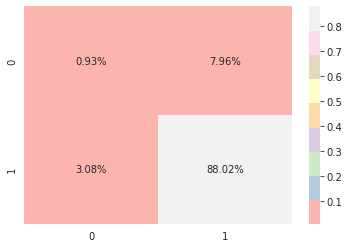

recall 2차 : 0.9677372282140062
precision 2차:  0.9152259553860437
f1_2차 :  0.9407493858285993
              precision    recall  f1-score   support

           0       0.24      0.10      0.14      7521
           1       0.92      0.97      0.94     75381

    accuracy                           0.89     82902
   macro avg       0.58      0.53      0.54     82902
weighted avg       0.85      0.89      0.87     82902



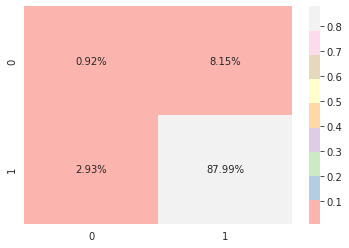

f1 avg score : 0.9408478423527404


In [243]:
result(qd, x_train,y_train, x_test, y_test, x,y,x_val,y_val)

recall 1차 : 0.9671000265322367
precision 1차:  0.9169811320754717
f1_1차 :  0.9413739669421487
              precision    recall  f1-score   support

           0       0.23      0.10      0.14      5151
           1       0.92      0.97      0.94     52766

    accuracy                           0.89     57917
   macro avg       0.58      0.54      0.54     57917
weighted avg       0.86      0.89      0.87     57917



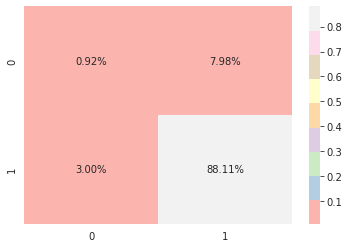

recall 2차 : 0.9678168238680834
precision 2차:  0.9152323364110799
f1_2차 :  0.9407903644909827
              precision    recall  f1-score   support

           0       0.24      0.10      0.14      7521
           1       0.92      0.97      0.94     75381

    accuracy                           0.89     82902
   macro avg       0.58      0.53      0.54     82902
weighted avg       0.85      0.89      0.87     82902



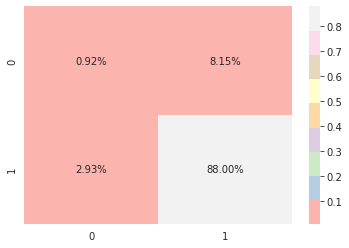

f1 avg score : 0.9410821657165658


In [244]:
result(qd, df_x_train,y_train, df_x_test, y_test, df_x,y,df_x_val,y_val)

- 정규화 전: f1 avg score : 0.9408478423527404


- 정규화 후: f1 avg score : 0.9410821657165658

제출 One more time
--

In [260]:
x_A=tn_A.drop(['target','person_prefer_d_1_n', 'person_prefer_d_2_n',
       'person_prefer_d_3_n', 'person_prefer_d_3',
       'contents_attribute_d_n', 'person_prefer_d_1', 'person_prefer_d_2',
       'contents_attribute_d', 'person_prefer_d_1_s',
       'person_prefer_d_2_s', 'contents_attribute_d_s',
       'person_prefer_d_3_s', 'person_prefer_d_1_m',
       'person_prefer_d_3_m', 'contents_attribute_d_m',
       'person_prefer_d_2_m', 'person_prefer_h_1_m',
       'person_prefer_h_1_l', 'person_prefer_d_2_l',
       'person_prefer_d_1_l', 'contents_attribute_d_l'], axis=1)
y_A=tn_A['target']

t_A=test.drop(['person_prefer_d_1_n', 'person_prefer_d_2_n',
       'person_prefer_d_3_n', 'person_prefer_d_3',
       'contents_attribute_d_n', 'person_prefer_d_1', 'person_prefer_d_2',
       'contents_attribute_d', 'person_prefer_d_1_s',
       'person_prefer_d_2_s', 'contents_attribute_d_s',
       'person_prefer_d_3_s', 'person_prefer_d_1_m',
       'person_prefer_d_3_m', 'contents_attribute_d_m',
       'person_prefer_d_2_m', 'person_prefer_h_1_m',
       'person_prefer_h_1_l', 'person_prefer_d_2_l',
       'person_prefer_d_1_l', 'contents_attribute_d_l'], axis=1)

In [261]:
ss=StandardScaler()
s_x_A=ss.fit_transform(x_A)
s_t_A=ss.fit_transform(t_A)

df_x_A=pd.DataFrame(s_x_A , index=x_A.index , columns=x_A.columns )
df_t_A=pd.DataFrame(s_t_A , index=t_A.index , columns=t_A.columns )

In [265]:
qd=QuadraticDiscriminantAnalysis()

recall : 0.9684067850664753
precision :  0.9153700933382068
f1  :  0.9411418299032979
              precision    recall  f1-score   support

           0       0.25      0.11      0.15     25111
           1       0.92      0.97      0.94    250845

    accuracy                           0.89    275956
   macro avg       0.58      0.54      0.54    275956
weighted avg       0.85      0.89      0.87    275956



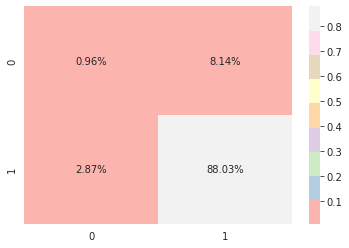

In [264]:
qd.fit(df_x_A, y_A)
y_pred=qd.predict(df_x_A)
f_1_1=f1_score(y_A,y_pred)
recall_1=recall_score(y_A, y_pred)
precision_1=precision_score(y_A, y_pred)
print("recall :", recall_1)
print("precision : ", precision_1)
print("f1  : ", f_1_1)
auc_roc=classification_report(y_A, y_pred)
print(auc_roc)
conf=confusion_matrix(y_A, y_pred)
sns.heatmap(conf/np.sum(conf), annot=True, cmap='Pastel1', fmt='.2%')
plt.show()

In [266]:
qd.fit(df_x_A, y_A)
y_pred=qd.predict(df_t_A)

In [267]:
df_pred=pd.DataFrame(y_pred, columns=['target'])

([<matplotlib.patches.Wedge at 0x7f151d5aca10>,
 [Text(-0.3536010419181176, -1.0416171576709083, 'target_0'),
  Text(0.35360113944135285, 1.0416171245643848, 'target_1')],
 [Text(-0.19287329559170047, -0.5681548132750408, '4.9%'),
  Text(0.19287334878619244, 0.5681547952169371, '95.1%')])

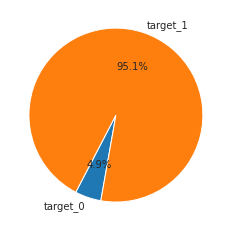

In [268]:
zero=len(df_pred.loc[df_pred['target']==0].index)
one=len(df_pred.loc[df_pred['target']==1].index)
ratio=[zero, one]
labels=['target_0', 'target_1']
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False)

In [269]:
df_pred['target'].value_counts()

1    44148
0     2256
Name: target, dtype: int64

In [270]:
sub_1.drop('target',axis=1, inplace=True)
sub_qda=pd.concat([sub_1, df_pred], axis=1)

In [272]:
sub_qda.to_csv("sub_qda_2.csv", index=False)

- Score: 0.6684 전에 제출했던 QDA모델로 돌린 파일보다 0.004점 올랐으나 여전히 ExtraClassifier Score를 따라오지 못함.

# Hyperparameter Tuning(AutoML)

사용하고자 하는 AutoML: AutoGluon, Auto-sklearn,TPOT, PyCaret

최종 학습 데이터가 완료 되었으면, AutoML을 통해 모델을 해석하여, model selection&feature selection&feature engineering을 마지막으로 검토하고, Hyperparameter Tuning을 통해 실제 대회에 제출하도록 한다.

Hyperparameter Tuning에 앞서서 마지막으로 모델 점검 후 최종 선택
--

In [53]:
def result(model, x_train,y_train, x_test, y_test, x,y,x_val,y_val):
  model.fit(x_train, y_train)
  y_pred_1=model.predict(x_test)
  f_1_1=f1_score(y_test,y_pred_1)
  recall_1=recall_score(y_test, y_pred_1)
  precision_1=precision_score(y_test, y_pred_1)
  print("recall 1차 :", recall_1)
  print("precision 1차: ", precision_1)
  print("f1_1차 : ", f_1_1)
  auc_roc=classification_report(y_test, y_pred_1)
  print(auc_roc)
  conf=confusion_matrix(y_test, y_pred_1)
  sns.heatmap(conf/np.sum(conf), annot=True, cmap='Pastel1', fmt='.2%')
  plt.show()

  model.fit(x, y)
  y_pred_2=model.predict(x_val)
  f_1_2=f1_score(y_val, y_pred_2)
  recall_2=recall_score(y_val, y_pred_2)
  precision_2=precision_score(y_val, y_pred_2)
  print("recall 2차 :", recall_2)
  print("precision 2차: ", precision_2)
  print("f1_2차 : ", f_1_2 )
  auc_roc=classification_report(y_val, y_pred_2)
  print(auc_roc)
  conf=confusion_matrix(y_val, y_pred_2)
  sns.heatmap(conf/np.sum(conf), annot=True, cmap='Pastel1', fmt='.2%')
  plt.show()

  f_1_a=(f_1_1+f_1_2)/2
  print("f1 avg score :", f_1_a)

In [54]:
# 1차 검증
x_train=tn_tn.drop(['target','d_s_match_yn', 'd_m_match_yn'], axis=1)
y_train=tn_tn['target']
x_test=tn_te.drop(['target','d_s_match_yn', 'd_m_match_yn'], axis=1)
y_test=tn_te['target']

# 2차 검증
x=tn.drop(['target','d_s_match_yn', 'd_m_match_yn'], axis=1)
y=tn['target']
x_val=val.drop(['target','d_s_match_yn', 'd_m_match_yn'], axis=1)
y_val=val['target']

**QDA**

recall 1차 : 0.9527726187317591
precision 1차:  0.9196575567994731
f1_1차 :  0.935922257800283
              precision    recall  f1-score   support

           0       0.23      0.15      0.18      5151
           1       0.92      0.95      0.94     52766

    accuracy                           0.88     57917
   macro avg       0.58      0.55      0.56     57917
weighted avg       0.86      0.88      0.87     57917



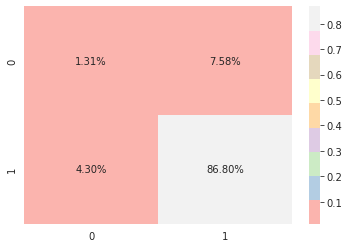

recall 2차 : 0.9543518923866757
precision 2차:  0.9185979697375981
f1_2차 :  0.9361336664584634
              precision    recall  f1-score   support

           0       0.25      0.15      0.19      7521
           1       0.92      0.95      0.94     75381

    accuracy                           0.88     82902
   macro avg       0.58      0.55      0.56     82902
weighted avg       0.86      0.88      0.87     82902



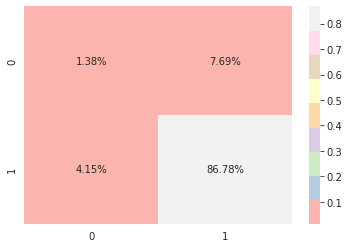

f1 avg score : 0.9360279621293732


In [55]:
result(qd, x_train, y_train, x_test, y_test, x, y, x_val, y_val)

**LDA**

recall 1차 : 0.9996588712428458
precision 1차:  0.9112393324810835
f1_1차 :  0.9534034631095687
              precision    recall  f1-score   support

           0       0.42      0.00      0.01      5151
           1       0.91      1.00      0.95     52766

    accuracy                           0.91     57917
   macro avg       0.67      0.50      0.48     57917
weighted avg       0.87      0.91      0.87     57917



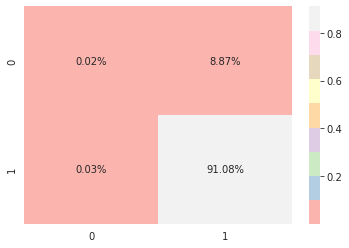

recall 2차 : 0.9997346811530757
precision 2차:  0.9094320951898245
f1_2차 :  0.9524477557236473
              precision    recall  f1-score   support

           0       0.44      0.00      0.00      7521
           1       0.91      1.00      0.95     75381

    accuracy                           0.91     82902
   macro avg       0.68      0.50      0.48     82902
weighted avg       0.87      0.91      0.87     82902



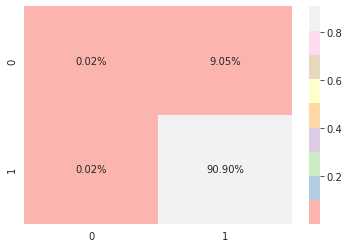

f1 avg score : 0.952925609416608


In [56]:
result(ld, x_train, y_train, x_test, y_test, x, y, x_val, y_val)

**extra**

recall 1차 : 0.9992987908880718
precision 1차:  0.9116828327886993
f1_1차 :  0.9534822744410187
              precision    recall  f1-score   support

           0       0.54      0.01      0.02      5151
           1       0.91      1.00      0.95     52766

    accuracy                           0.91     57917
   macro avg       0.72      0.50      0.48     57917
weighted avg       0.88      0.91      0.87     57917



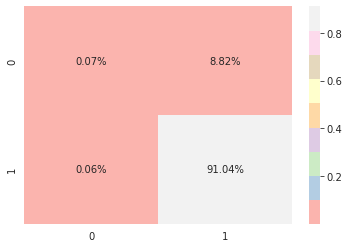

recall 2차 : 0.9991111818628037
precision 2차:  0.910083982840916
f1_2차 :  0.9525218799008449
              precision    recall  f1-score   support

           0       0.54      0.01      0.02      7521
           1       0.91      1.00      0.95     75381

    accuracy                           0.91     82902
   macro avg       0.73      0.50      0.49     82902
weighted avg       0.88      0.91      0.87     82902



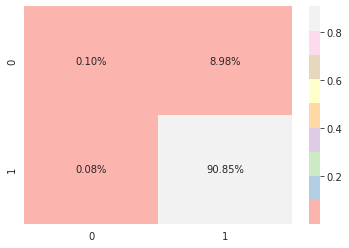

f1 avg score : 0.9530020771709318


In [57]:
result(extra, x_train, y_train, x_test, y_test, x, y, x_val, y_val)

최종모델 선정: QDA, ExtraTreeClassifier
--

> 선정이유
- 1이 압도적인 데이터에서 1을 얼마냐 잘 맞추느냐에 초점을 두지 않음. 결국 숨겨져 있는 0을 0으로 얼마냐 잘 맞추냐가 포인트인데, 이러한 점에서 QDA가 다른 두 개의 모델보다 성능이 좋음. 따라서, 기존에 분석하던 ExtraTreeClassifier와 함께 QDA를 최종 모델로 선정



**QDA로 제출해보기**

In [62]:
qd=QuadraticDiscriminantAnalysis()

In [63]:
x_A=tn_A.drop(['target','d_s_match_yn', 'd_m_match_yn'], axis=1)
y_A=tn_A['target']

In [64]:
qd.fit(x_A, y_A)

QuadraticDiscriminantAnalysis()

In [66]:
test_A=test.drop(['d_s_match_yn', 'd_m_match_yn'], axis=1)

In [67]:
pred=qd.predict(test_A)

In [71]:
df_pred=pd.DataFrame(pred, columns=['target'])
df_pred['target'].value_counts()

1    38251
0     8153
Name: target, dtype: int64

([<matplotlib.patches.Wedge at 0x7f9158c72150>,
 [Text(-0.7306818551602474, -0.8222554509029292, 'target_0'),
  Text(0.7306818166676909, 0.8222554851086146, 'target_1')],
 [Text(-0.3985537391783167, -0.44850297321977955, '17.6%'),
  Text(0.39855371818237684, 0.4485029918774261, '82.4%')])

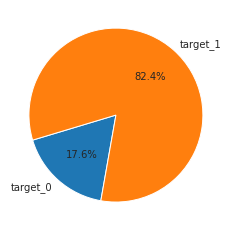

In [72]:
zero=len(df_pred.loc[df_pred['target']==0].index)
one=len(df_pred.loc[df_pred['target']==1].index)
ratio=[zero, one]
labels=['target_0', 'target_1']
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False)

In [74]:
sub_1.drop('target', axis=1, inplace=True)
sub=pd.concat([sub_1, df_pred['target']], axis=1)

In [76]:
#sub.to_csv("sub_qda.csv", index=False)

|target_1|target_0|score|
|--|--|--|
|82.4|17.6|0.66455|

Hyperparameter Tuning
--

QDA & ExtraTreeClassifier



**Grid Search CV**

qd: Hyperparameter Tuning 필요없음

In [43]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
#from sklearn.model_selection import GridSearchCV
#
#param_grid=[{'n_estimators':[10,50,100,500],
#             'criterion':['gini','entropy'],
#             'max_depth':[10,50,100],
#             'min_samples_split':[2,3,5],
#             'random_state':[42]}]
#
#extra=ExtraTreesClassifier()
#grid_search=GridSearchCV(extra, param_grid, cv=5, scoring='f1',return_train_score= True)
#grid_search.fit(x_A, y_A)

In [130]:
#grid_search.best_params_

{'reg_param': 0.0}

- 런타임 터짐

**BayesianOptimization**

In [ ]:
!pip install bayesian-optimization

In [45]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

In [120]:
x=tn.drop(['target','d_s_match_yn', 'd_m_match_yn'], axis=1)
y=tn['target']
x_val=val.drop(['target','d_s_match_yn', 'd_m_match_yn'], axis=1)
y_val=val['target']

In [126]:
param_grid={'n_estimators':(10,500),
             'max_depth':(10 ,100),
             'min_samples_split':(2.0,5.0)}

In [127]:
def extra_hyper_param(n_estimators, max_depth, min_samples_split):
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    extra=ExtraTreesClassifier(n_estimators=n_estimators,
                              max_depth=max_depth, min_samples_split=min_samples_split)
    extra.fit(x, y)
    y_pred=extra.predict(x_val)
    f1=f1_score(y_val, y_pred)
    return f1

In [128]:
optimizer = BayesianOptimization(f=extra_hyper_param, pbounds=param_grid, random_state=42)

In [ ]:
optimizer.maximize(init_points=24, n_iter=3, acq='ei', xi=1)

- 에러때문에 포기

# Active Learning

In [ ]:
!pip install modAL

In [247]:
from modAL.models import ActiveLearner

In [250]:
#result(qd, df_x_train,y_train, df_x_test, y_test, df_x,y,df_x_val,y_val)
learner = ActiveLearner(
    estimator=ExtraTreesClassifier(),
    X_training=df_x_train, y_training=y_train
)

In [252]:
query_idx, query_inst = learner.query(df_x_test)

In [ ]:
df_x_test[query_idx].reshape(-1,1)

In [ ]:
learner.teach(df_x_test[query_idx], y_test)

In [ ]:
def result(model, x_train,y_train, x_test, y_test, x,y,x_val,y_val):
  model.fit(x_train, y_train)
  y_pred_1=model.predict(x_test)
  f_1_1=f1_score(y_test,y_pred_1)
  recall_1=recall_score(y_test, y_pred_1)
  precision_1=precision_score(y_test, y_pred_1)
  print("recall 1차 :", recall_1)
  print("precision 1차: ", precision_1)
  print("f1_1차 : ", f_1_1)
  auc_roc=classification_report(y_test, y_pred_1)
  print(auc_roc)
  conf=confusion_matrix(y_test, y_pred_1)
  sns.heatmap(conf/np.sum(conf), annot=True, cmap='Pastel1', fmt='.2%')
  plt.show()

  model.fit(x, y)
  y_pred_2=model.predict(x_val)
  f_1_2=f1_score(y_val, y_pred_2)
  recall_2=recall_score(y_val, y_pred_2)
  precision_2=precision_score(y_val, y_pred_2)
  print("recall 2차 :", recall_2)
  print("precision 2차: ", precision_2)
  print("f1_2차 : ", f_1_2 )
  auc_roc=classification_report(y_val, y_pred_2)
  print(auc_roc)
  conf=confusion_matrix(y_val, y_pred_2)
  sns.heatmap(conf/np.sum(conf), annot=True, cmap='Pastel1', fmt='.2%')
  plt.show()

  f_1_a=(f_1_1+f_1_2)/2
  print("f1 avg score :", f_1_a)